In [1]:
from nircam_disk_utils import gen_roll_images_hg3
from astropy.io import fits
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr # Import CMasher to register colormaps
import numpy as np
import matplotlib as mpl

In [2]:
f300m_roll1_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/jw01386117001_03106_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"
f300m_roll2_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F300M/jk/231108/jw01386118001_03106_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"
f360m_roll1_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F360M/jk/231108/jw01386117001_03107_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"
f360m_roll2_filename = "/home/maxmb/Library/jwst_hd141569a_lib/data/F360M/jk/231108/jw01386118001_03107_00001_nrcalong_calints_mstar_subtracted_MCRDI_psf_subtracted.fits"


f300m_roll1_hdul = fits.open(f300m_roll1_filename)
f300m_roll2_hdul = fits.open(f300m_roll2_filename)
f360m_roll1_hdul = fits.open(f360m_roll1_filename)
f360m_roll2_hdul = fits.open(f360m_roll2_filename)

f300m_roll1_data = f300m_roll1_hdul[0].data
f300m_roll2_data = f300m_roll2_hdul[0].data
f360m_roll1_data = f360m_roll1_hdul[0].data
f360m_roll2_data = f360m_roll2_hdul[0].data

data_shape_f300m = f300m_roll1_data.shape


In [3]:
#############################################################################
########## Crop the data to fit the disk in only part of the image ##########
#############################################################################
y1 = 100
y2 = 240
x1 = 80
x2 = 220
sci1_data_crop_f300m = f300m_roll1_data[y1:y2,x1:x2].astype(jnp.float32)
sci2_data_crop_f300m = f300m_roll2_data[y1:y2,x1:x2].astype(jnp.float32)
sci1_data_crop_f360m = f360m_roll1_data[y1:y2,x1:x2].astype(jnp.float32)
sci2_data_crop_f360m = f360m_roll2_data[y1:y2,x1:x2].astype(jnp.float32)

data_crop_shape = sci1_data_crop_f300m.shape

osamp=2

In [4]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

##################### F300M #################
psf_dir = "/home/maxmb/Library/jwst_hd141569a_lib/PSFs/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
im_mask = im_mask_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_inds = psf_inds_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f300m = [psfs,psf_inds,im_mask,unique_inds]


psf_dir = "/home/maxmb/Library/jwst_hd141569a_lib/PSFs/F360M/"
psf_suffixes = "_F360M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
im_mask = im_mask_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_inds = psf_inds_rolls[0][y1*osamp:y2*osamp,x1*osamp:x2*osamp]
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f360m = [psfs,psf_inds,im_mask,unique_inds]

In [5]:
######################################
######### Simulation Setup ###########
######################################
pixel_scale=0.063 # nircam pixel scale in arcsec/px
nx = x2-x1 # number of pixels of your image in X
ny = y2-y1 # number of pixels of your image in Y
cent = [173.4-y1,149.1-x1] #[y_cent,x_cent] #Cropped cent


In [6]:
########################################################
######### Scaling values for some parameters ###########
########################################################

############# SMA ##############
#Parameters from October
a0_1 = 40.0  # semimajoraxis of the inner disk in au
a0_2 = 220.0  # semimajoraxis of the inner disk in au
a0_3 = 510.0  # semimajoraxis of the inner disk in au
a0_4 = 330.0

################# Relative flux #####################
#Parameters from October
f0_1 = 3e4
f0_2 = 7.5e3
f0_3 = 140
f0_4 = 410

# A scaling factor because the new data slightly brighter than the old data
new_flux_scaling = 1.23
f0_1 *= new_flux_scaling
f0_2 *= new_flux_scaling
f0_3 *= new_flux_scaling
f0_4 *= new_flux_scaling

In [7]:
data_shape = f300m_roll1_data.shape
pixel_scale_f300m = np.sqrt(f300m_roll1_hdul[1].header['PIXAR_A2'])

#Coronagraphic center: 
coron_center = [173.4,149.1]

#F300M - pixel sizes and plotting range. 
x_size_f300m = f300m_roll1_data.shape[1]
y_size_f300m = f300m_roll1_data.shape[0]
x_f300m = np.arange(x_size_f300m)
y_f300m = np.arange(y_size_f300m)
x_f300m = (x_f300m-coron_center[1])*pixel_scale_f300m
y_f300m = (y_f300m-coron_center[0])*pixel_scale_f300m
xx_f300m,yy_f300m = np.meshgrid(x_f300m,y_f300m)

#Now for the cropped data
x_size_crop = data_crop_shape[1]
y_size_crop = data_crop_shape[0]
x_crop = np.arange(x_size_crop)
y_crop = np.arange(y_size_crop)
x_crop_f300m = (x_crop-cent[1])*pixel_scale_f300m
y_crop_f300m = (y_crop-cent[0])*pixel_scale_f300m
# xx_crop,yy_crop = np.meshgrid(x_crop,y_crop)


In [8]:
### Starting point based on a previous fit. 
# x0 = jnp.load("../231108/hg3fit_F300M_m_stars_bounded_quad.npz.npy")
x0_f300m = jnp.load("hg3fit_F300M_m_stars_bounded_quad_new.npz.npy")
x0_f360m = jnp.load("hg3fit_F360M_full_params.npy")
n_nodes = 6 #Number of parameters associated with the scattering phase function. 

In [9]:
model_f300m_roll1, model_f300m_roll2 = gen_roll_images_hg3(x0_f300m,cent,nircam_psf_list_f300m,f0_1=f0_1,f0_2=f0_2,f0_3=f0_3,f0_4=f0_4,
                        a0_1=a0_1,a0_2=a0_2,a0_3=a0_3,a0_4=a0_4,
                        nx=nx,ny=ny,n_nodes=6)



/home/maxmb/anaconda3/envs/new_jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/maxmb/anaconda3/envs/new_jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:64: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
2024-12-26 20:42:17.431091: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algo

In [10]:
############# SMA ##############
#Parameters from October
a0_1 = 40.0  # semimajoraxis of the inner disk in au
a0_2 = 220.0  # semimajoraxis of the inner disk in au
a0_3 = 510.0  # semimajoraxis of the inner disk in au
a0_4 = 330.0

################# Relative flux #####################
#Parameters from October
f0_1 = 1.5e5
f0_2 = 2.5e3
f0_3 = 140
f0_4 = 410

model_f360m_roll1, model_f360m_roll2 = gen_roll_images_hg3(x0_f360m,cent,nircam_psf_list_f360m,
                        f0_1=f0_1,f0_2=f0_2,f0_3=f0_3,f0_4=f0_4,
                        a0_1=a0_1,a0_2=a0_2,a0_3=a0_3,a0_4=a0_4,
                        nx=nx,ny=ny,n_nodes=6)

In [11]:
conversion_factor_f300m = f300m_roll1_hdul[1].header["PHOTUJA2"]/f300m_roll1_hdul[1].header["PHOTMJSR"]
conversion_factor_f360m = f360m_roll1_hdul[1].header["PHOTUJA2"]/f360m_roll1_hdul[1].header["PHOTMJSR"]

f300m_roll1_data *= conversion_factor_f300m
f300m_roll2_data *= conversion_factor_f300m
f360m_roll1_data *= conversion_factor_f360m
f360m_roll2_data *= conversion_factor_f360m

model_f300m_roll1 *= conversion_factor_f300m
model_f300m_roll2 *= conversion_factor_f300m

model_f360m_roll1 *= conversion_factor_f360m
model_f360m_roll2 *= conversion_factor_f360m

In [12]:
max_box_size = 40

f300m_vmax=1400
f300m_vmin = 0
linthresh = 0.1

f360m_vmax=2200
f360m_vmin = 0

cmap = plt.get_cmap('cmr.freeze')

gamma = 0.3
#Make a Linear LogNorm, SymLogNorm and PowerNorm dictionary: 
norms_f300m = {'linear': mpl.colors.Normalize(vmin=f300m_vmin,vmax=f300m_vmax),
         'log': mpl.colors.LogNorm(vmin=f300m_vmin,vmax=f300m_vmax),
         'symlog': mpl.colors.SymLogNorm(linthresh=linthresh,vmin=f300m_vmin,vmax=f300m_vmax),
         'power': mpl.colors.PowerNorm(gamma=gamma,vmin=f300m_vmin,vmax=f300m_vmax)}

norms_f360m = {'linear': mpl.colors.Normalize(vmin=f360m_vmin,vmax=f360m_vmax),
         'log': mpl.colors.LogNorm(vmin=f360m_vmin,vmax=f360m_vmax),
         'symlog': mpl.colors.SymLogNorm(linthresh=linthresh,vmin=f360m_vmin,vmax=f360m_vmax),
         'power': mpl.colors.PowerNorm(gamma=gamma,vmin=f360m_vmin,vmax=f360m_vmax)}

norm_key = "power"


In [13]:
roll1_f300m = f300m_roll1_hdul[0].header['GS_V3_PA']
roll2_f300m = f300m_roll2_hdul[0].header['GS_V3_PA']
roll1_f360m = f360m_roll1_hdul[0].header['GS_V3_PA']
roll2_f360m = f360m_roll2_hdul[0].header['GS_V3_PA']

from deconvolution_utils import pyklip_rotate
# from pyklip.klip import rotate

roll_offset = -90

derotated_roll1_f300m = pyklip_rotate(f300m_roll1_data.astype(jnp.float32),roll1_f300m+roll_offset,coron_center[::-1],new_center=coron_center[::-1])
derotated_roll2_f300m = pyklip_rotate(f300m_roll2_data.astype(jnp.float32),roll2_f300m+roll_offset,coron_center[::-1],new_center=coron_center[::-1])
combined_f300m = np.mean([derotated_roll1_f300m,derotated_roll2_f300m],axis=0)
derotated_roll1_f360m = pyklip_rotate(f360m_roll1_data.astype(jnp.float32),roll1_f360m+roll_offset,coron_center[::-1],new_center=coron_center[::-1])
derotated_roll2_f360m = pyklip_rotate(f360m_roll2_data.astype(jnp.float32),roll2_f360m+roll_offset,coron_center[::-1],new_center=coron_center[::-1])
combined_f360m = np.mean([derotated_roll1_f360m,derotated_roll2_f360m],axis=0)

derotated_model_roll1_f300m = pyklip_rotate(model_f300m_roll1,roll1_f300m+roll_offset,cent[::-1],new_center=cent[::-1])
derotated_model_roll2_f300m = pyklip_rotate(model_f300m_roll2,roll2_f300m+roll_offset,cent[::-1],new_center=cent[::-1])
combined_model_f300m = np.mean([derotated_model_roll1_f300m,derotated_model_roll2_f300m],axis=0)
derotated_model_roll1_f360m = pyklip_rotate(model_f360m_roll1,roll1_f360m+roll_offset,cent[::-1],new_center=cent[::-1])
derotated_model_roll2_f360m = pyklip_rotate(model_f360m_roll2,roll2_f360m+roll_offset,cent[::-1],new_center=cent[::-1])
combined_model_f360m = np.mean([derotated_model_roll1_f360m,derotated_model_roll2_f360m],axis=0)


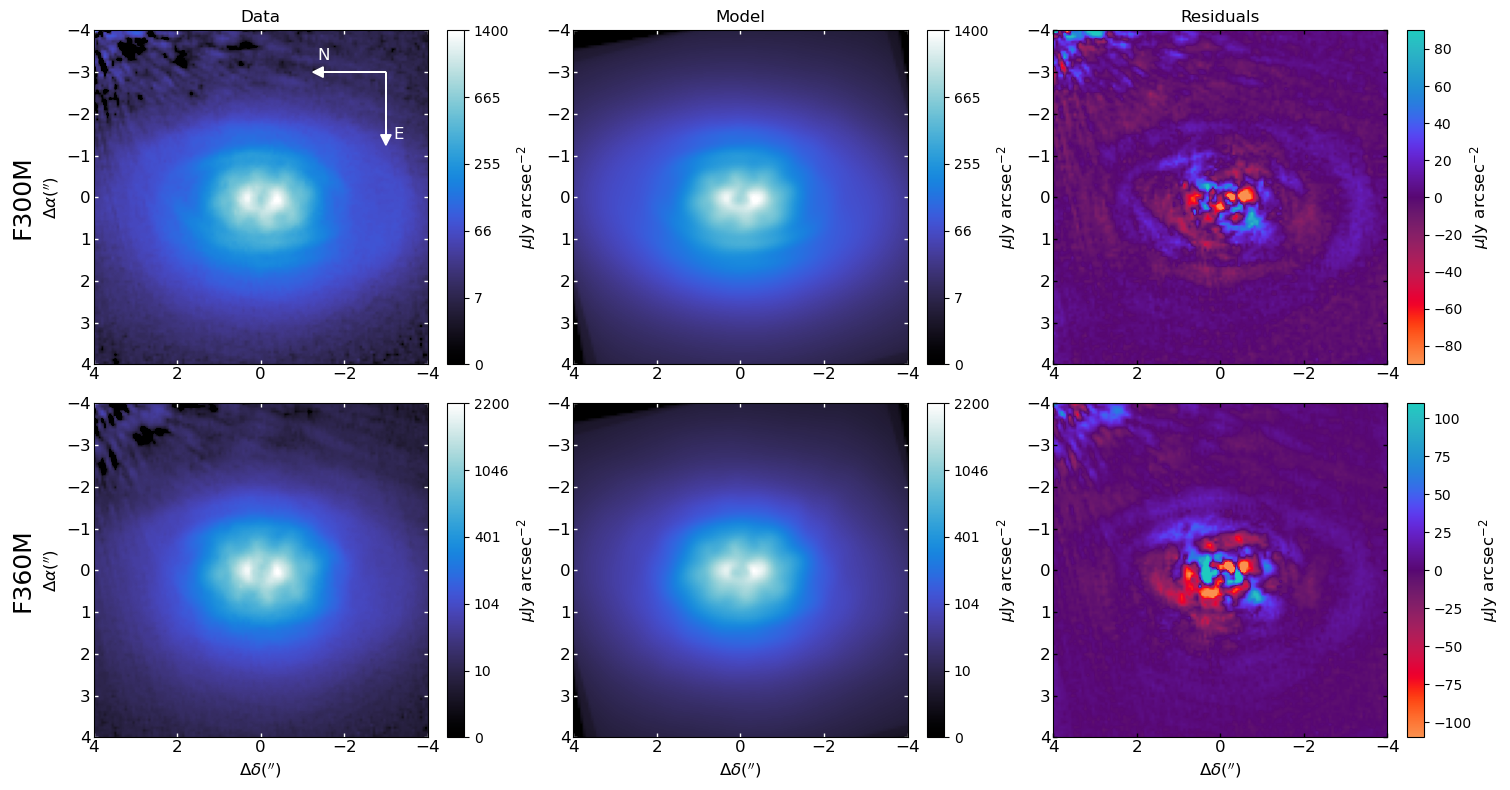

In [14]:
fig, axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

############################################
############## F300M #######################
############################################

im_data_f300m = axes[0].imshow(combined_f300m,origin='lower',
                cmap=cmap,norm = norms_f300m[norm_key],
                extent=[x_f300m[0],x_f300m[-1],y_f300m[0],y_f300m[-1]])
axes[0].set_title("Data")

n_cbar_ticks = 6
ticks = np.linspace(0,1,n_cbar_ticks)
data_tick_values_f300m = ticks**(1/gamma)*(f300m_vmax-f300m_vmin)+f300m_vmin
data_tick_values_f360m = ticks**(1/gamma)*(f360m_vmax-f360m_vmin)+f360m_vmin
cbar1 = plt.colorbar(im_data_f300m, ax=axes[0], ticks=data_tick_values_f300m,fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False))
cbar1.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)

im_model_f300m = axes[1].imshow(combined_model_f300m,origin='lower',
                cmap=cmap,norm = norms_f300m[norm_key],
                extent=[x_crop_f300m[0],x_crop_f300m[-1],y_crop_f300m[0],y_crop_f300m[-1]])
axes[1].set_title("Model")
cbar2 = plt.colorbar(im_model_f300m, ax=axes[1], ticks=data_tick_values_f300m,fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False)
cbar2.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)


cmap_diverging = plt.get_cmap('cmr.guppy')
im_residuals_f300m = axes[2].imshow(combined_f300m[y1:y2,x1:x2]-combined_model_f300m,origin="lower",
                cmap = cmap_diverging, 
                # vmin=-3*conversion_factor_f300m, vmax=3*conversion_factor_f300m,
                vmin=-90,vmax=90,
                extent=[x_crop_f300m[0],x_crop_f300m[-1],y_crop_f300m[0],y_crop_f300m[-1]]
                )
axes[2].set_title("Residuals")
cbar3 = plt.colorbar(im_residuals_f300m, ax=axes[2],fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False))
cbar3.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)

############################################
############## F360M #######################
############################################


im_data_f360m = axes[3].imshow(combined_f360m,origin='lower',
                cmap=cmap,norm = norms_f360m[norm_key],
                extent=[x_f300m[0],x_f300m[-1],y_f300m[0],y_f300m[-1]])

n_cbar_ticks = 6
ticks = np.linspace(0,1,n_cbar_ticks)
cbar4 = plt.colorbar(im_data_f360m, ax=axes[3], ticks=data_tick_values_f360m,fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False))
cbar4.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)

im_model_f360m = axes[4].imshow(combined_model_f360m,origin='lower',
                cmap=cmap,norm = norms_f360m[norm_key],
                extent=[x_crop_f300m[0],x_crop_f300m[-1],y_crop_f300m[0],y_crop_f300m[-1]])
cbar5 = plt.colorbar(im_model_f360m, ax=axes[4], ticks=data_tick_values_f360m,fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False))
cbar5.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)

im_residuals_f360m = axes[5].imshow(combined_f360m[y1:y2,x1:x2]-combined_model_f360m,origin="lower",
                cmap = cmap_diverging, 
                # vmin=-3*conversion_factor_f360m, vmax=3*conversion_factor_f360m,
                vmin=-110,vmax=110,
                extent=[x_crop_f300m[0],x_crop_f300m[-1],y_crop_f300m[0],y_crop_f300m[-1]]
                )
cbar6 = plt.colorbar(im_residuals_f360m, ax=axes[5],fraction=0.046,)# format=mpl.colors.LogFormatter(labelOnlyBase=False))
cbar6.set_label(label=r'$\mu $Jy arcsec$^{-2}$',size=12)

##########################################################
############## Make a compass rose #######################
##########################################################

arrow_length = 1.5
compass_center = [-3,-3]
north_angle = 0
east_angle = -90
head_width = 0.25
head_length = 0.25
# Draw North arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(north_angle)), -arrow_length * np.sin(np.radians(north_angle)), head_width=head_width, head_length=head_length, fc='w', ec='w')
# Draw North label
axes[0].text(arrow_length * np.cos(np.radians(north_angle))+compass_center[0], -arrow_length * np.sin(np.radians(north_angle))+compass_center[1]-0.4, 'N', color='w', ha='center', va='center',fontsize=12)

# # Draw East arrow
axes[0].arrow(compass_center[0], compass_center[1], arrow_length * np.cos(np.radians(east_angle)), -arrow_length * np.sin(np.radians(east_angle)), head_width=head_width, head_length=head_length, fc='w', ec='w')
# # Draw East label
axes[0].text(arrow_length * np.cos(np.radians(east_angle))+compass_center[0]-0.3, -arrow_length * np.sin(np.radians(east_angle))+compass_center[1], 'E', color='w', ha='center', va='center',fontsize=12)

##############################################
############## Plot Formatting ###############
##############################################

axes[0].set_xlim(4,-4)
axes[1].set_xlim(4,-4)
axes[2].set_xlim(4,-4)
axes[3].set_xlim(4,-4)
axes[4].set_xlim(4,-4)
axes[5].set_xlim(4,-4)

axes[0].set_ylim(4,-4)
axes[1].set_ylim(4,-4)
axes[2].set_ylim(4,-4)
axes[3].set_ylim(4,-4)
axes[4].set_ylim(4,-4)
axes[5].set_ylim(4,-4)


# axes[0].set_xlabel(r"$\Delta \alpha ('')$",fontsize=12)
axes[0].set_ylabel(r"$\Delta \alpha ('')$",fontsize=12)
axes[3].set_ylabel(r"$\Delta \alpha ('')$",fontsize=12)

axes[3].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)
axes[4].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)
axes[5].set_xlabel(r"$\Delta \delta ('')$",fontsize=12)



axes[0].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='white')
axes[1].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='white')
axes[2].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='k')

axes[3].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='white')
axes[4].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='white')
axes[5].tick_params(axis='both', which='both', labelsize=12, direction='in', pad=2, right=True, top=True, width=1.0, length=3, color='k')

#Filter Labels
axes[0].text(6, 0, 'F300M', fontsize=18, rotation='vertical', verticalalignment='center')
axes[3].text(6, 0, 'F360M', fontsize=18, rotation='vertical', verticalalignment='center')


plt.tight_layout()